In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # for backprop, we need to keep track of values that produced those values
        self._prev = set(_children)
        # and of the operation used
        self._op = _op
        self.label = label #for viz purposes

    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data+other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        return out

In [25]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
d

Value(data=4.0)

In [29]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [30]:
for prev in d._prev:
    print(prev._prev)
    print(prev._op)

set()

{Value(data=2.0), Value(data=-3.0)}
*


In [ ]:
# let's viz nicely
from graphviz import Digraph
def trace(root):
    # we backward navigate a tree, which is what we build with Value class
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


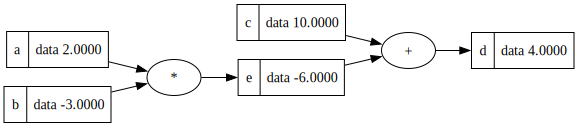

In [37]:
draw_dot(d)
# it's +, since it was the latest operation done

In [41]:
#let's be more complex

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

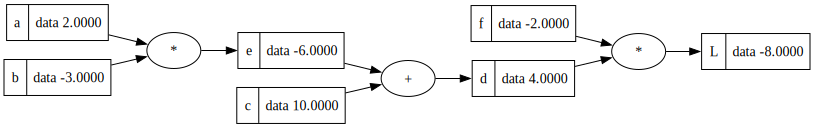

In [ ]:
# we are able to do mathematical expressions with + and *
# and able to keep track of the whole DAG expression that generated the final number
draw_dot(L)

In [51]:
# now we need to compute the derivative of our L(oss) in comparison of each var
# each var, in DL setup, it's the weight of the NN


class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 #when 0 it doens't affect loss function
        # for backprop, we need to keep track of values that produced those values
        self._prev = set(_children)
        # and of the operation used
        self._op = _op
        self.label = label #for viz purposes

    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data+other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        return out
    # used tanh for explanatory purposes, but we cooul potentially build any f tipycally used
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')
        return out
    
# let's viz nicely
from graphviz import Digraph
def trace(root):
    # we backward navigate a tree, which is what we build with Value class
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


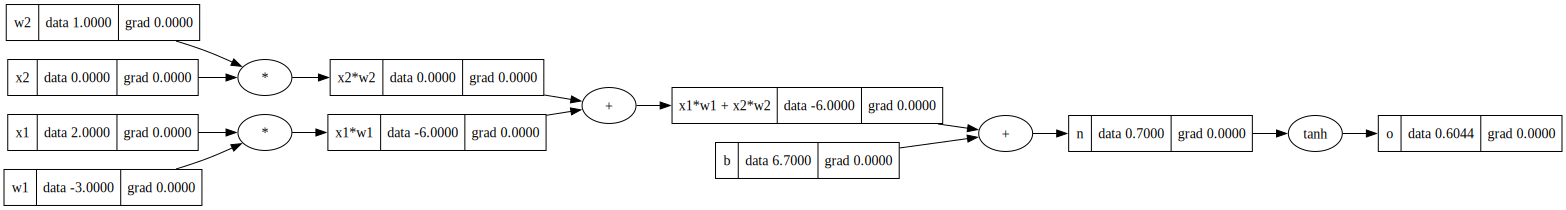

In [53]:
# forward pass of a NN
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [55]:
# backprop step by step example

# we only want to do backprop of our weights
# do/dn = 1 - tanh**2(n) = 1 - o**2,  since tanh(n) = 0
# PLEASE NOTE:  do/db = do/dn * dn/db = do/dn , since n = sth + b -> dn/db = 1 -> grads of + are basically the grads of value calculated before

# given derivative chain rule do/dw1 = do/dn * dn/dw1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dw1
# PLEASE NOTE: the chain rule tells us that this can be done recursively

# as we said, n = x1w1x2w2 + b -> dn/dx1w1x2w2 = 1
# do/dw1 = do/dn * dw1x1w2x2/dw1, since d(x1*w1 + x2*w2)/dw1 = x1 -> (1 - o**2)*x1 = 0 since x1=0
# do/dx1 = (1 - o**2)*w1
# do/dx2 = (1 - o**2)*w2
# do/dw2 = (1 - o**2)*x2

## PLEASE NOTE: instead when we have a *, the grad is basically the prev grad * the other value